# Analytical vs numerical approaches

We have now seen two different ways to answer questions like 'if I toss a fair coin 10 times, what is the probability of getting 7 or fewer heads from a fair coin'

* **Numerical approach** Use a simulation to generate many random samples from an equivalent process
* **Analytical approach** Use an exact equation (the PMF and CDF)

These approaches differ in important ways:

* The PMF and CDF are worked out from an equation rather than by random sampling
    * Therefore the probability values (eg $p(k<=7)$) given by `stats.binom.pmf()` and `stats.binom.cdf()` never change (for given values of $n,p,k$)
    * In contrast the values given by our simluations (how many random samples $k<=7$) did vary slightly each time we ran our simulation

Why would we ever run a simulation, when there is an equation (and a built in function in `scipy.stats`) that can tell us the exact answer?

Well, we probably wouldn't, *if* an easy analytical solution is available. But for many statistical problems, no such solution is available. You already saw one important case: **permutation testing**. To work out how often we would get a certain difference of means for a certain dataset due to chance, we needed to actually run a lot of random shuffles (numerical solution). Although we *could* in theory have solved this with an equation, it would have been a very messy equation and much more hassle than it is worth.

This page explores the relationship between analytical and numerical solutions, using the binomial distribution (where both are available) as an example - but the general ideas apply more broadly to any numerical solution to a statistical problem.

  
    


### Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [2]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Converting between probabilities and frequencies

In this notebook we will compare the output of simulations of the binomial distribution with the 'correct' values given by the PMF and CDF.

If we want to compare the outcomes of a simulation to the values given by the PMF and CDF functions in `scipy.stats`, we need to consider the following point:

* The PMF and CDF tell us the *probablity* of each outcome, which is always a number betwee 0 and 1
* The simulation tells us the frequency of each outcome out of a large number (eg nReps=10000) shuffles

For example:
* The CDF might tell us that the probability $p(k<=7)=0.945$
* A simulation tells us that the criterion k<=7 was met in 9450 out of 10000 random samples
    
Therefore if we plot the outputs of the PMF/CDF equations, and the outputs of the simulation, the $y$-axes have very different ranges:

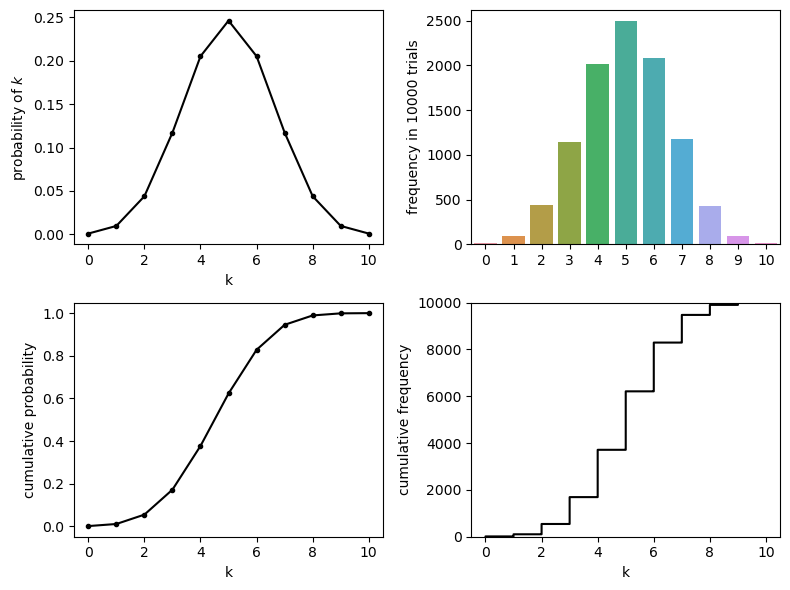

In [14]:
# simulate 10000 samples from k~B(10,0.5)
nReps=10000
k = np.random.binomial(10,0.5,nReps)

# Theoretical PMF and CDF for k~B(10,0.5)
pmf = stats.binom.pmf(range(11),10,0.5)
cdf = stats.binom.cdf(range(11),10,0.5)

plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
plt.plot(range(11), pmf, 'k.-')
plt.xlabel('k')
plt.ylabel('probability of $k$')

plt.subplot(2,2,3)
plt.plot(range(11), cdf, 'k.-')
plt.xlabel('k')
plt.ylabel('cumulative probability')

plt.subplot(2,2,2)
sns.countplot(x=k, order=range(11))
plt.ylabel('frequency in 10000 trials')

plt.subplot(2,2,4)
plt.xlabel('k')
sns.ecdfplot(x=k, color='k', stat='count') # note we are using a new plot type here! You can Google it!
plt.ylabel('cumulative frequency')

plt.tight_layout()
plt.show()

Eagle-eyed readers may notice that the $y$-axis for the simulations (with 10000 shuffles) is **10,000 times larger** than the $y$ axis for the probability distributions.

If we want to overlay the plots from the analytical PMF and CDF on the simulation, we need to multiply the *probability* of each value of $k$ by 10000, to get the expected *frequency* in 10000 shuffles:

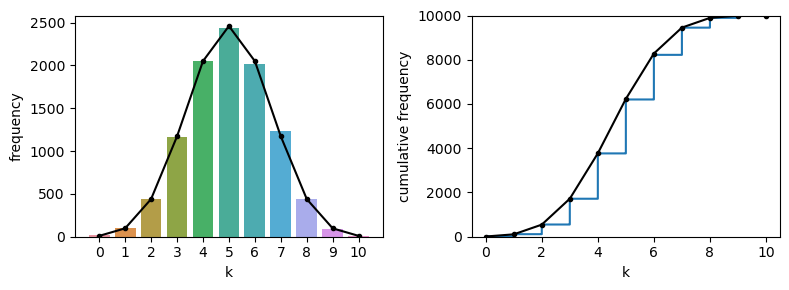

In [16]:
# simulate 10000 samples from k~B(10,0.5)
nReps=10000
k = np.random.binomial(10,0.5,nReps)

# Theoretical PMF and CDF for k~B(10,0.5)
pmf = stats.binom.pmf(range(11),10,0.5)
cdf = stats.binom.cdf(range(11),10,0.5)

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
sns.countplot(x=k, order=range(11))
plt.plot(range(11), pmf*nReps, 'k.-') # note we multiply by 10,000
plt.xlabel('k')
plt.ylabel('frequency')

plt.subplot(1,2,2)
sns.ecdfplot(x=k, stat='count')
plt.plot(range(11), cdf*nReps, 'k.-') # note we multiply by 10,000
plt.xlabel('k')
plt.ylabel('cumulative frequency')

plt.tight_layout()
plt.show()

## Varying nReps

The plots above show quite good agreement between the simulation (with 10000 shuffles or `nReps=10000`) and the exact probabilities given by the PMF.

As you may imagine, the quality of the match depends on the number of shuffles used.

In the code block below, many fewer shuffles are used (`nReps=100`); the simulation now becomes a rather less good match to the exact probabilities as given by the PMF

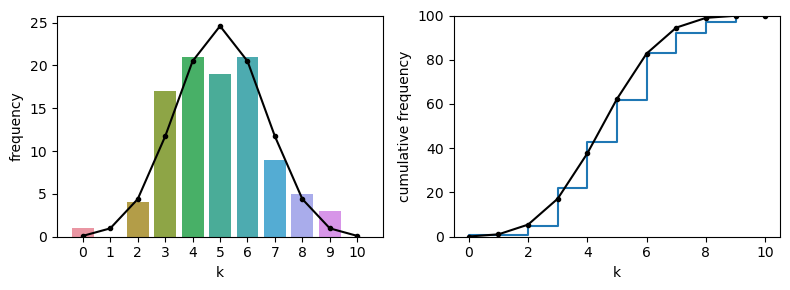

In [22]:
# simulate 100 samples from k~B(10,0.5)
nReps=100
k = np.random.binomial(10,0.5,nReps)

# Theoretical PMF and CDF for k~B(10,0.5)
pmf = stats.binom.pmf(range(11),10,0.5)
cdf = stats.binom.cdf(range(11),10,0.5)

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
sns.countplot(x=k, order=range(11))
plt.plot(range(11), pmf*nReps, 'k.-') # note we multiply by 10,000
plt.xlabel('k')
plt.ylabel('frequency')

plt.subplot(1,2,2)
sns.ecdfplot(x=k, stat='count')
plt.plot(range(11), cdf*nReps, 'k.-') # note we multiply by 10,000
plt.xlabel('k')
plt.ylabel('cumulative frequency')

plt.tight_layout()
plt.show()

*Note-*
* The simulation now becomes a rather less good match to the exact probabilities as given by the PMF
* The CDF is a bit of a closer match as errors balance out - for example if the simulation overestimates $p(k=4)$ and underestimates $p(k=5)$, then the cumulative $p(k<=6)$ is about right

Importantly, if you were to re-run the simulation, you would get a different histogram of values of $k$ - so the simulation with a small number of shuffles (small `nReps`) is not only less accurate, but *less stable* than a simulation with a large number of shuffles

* re run the code block above a couple of times to see the simulation change
* the PMF and CDF from the equation will *not* change as they are not random

### How many reps is enough?

If we want a numerical answer to this question, we need to think of a way to pose the question numerically.

How about this:

* What number of reps (shuffles) is needed to estimate the probability of k to within 1% of the correct answer?